In [1]:
import pandas as pd
import numpy as np 
import itertools as it
import matplotlib.pyplot as plt

In [2]:
import pickle
import time

In [3]:
from gensim.models import Word2Vec

C:\Users\moham\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [5]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Setup nltk corpora path and Google Word2Vec location
google_vec_file = r"C:\Users\moham\Metis Bootcamp\GoogleNewsVectors\GoogleNews-vectors-negative300.bin"

model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [6]:
#Open Corpus of News Article Text
with open('./data/news_data_frame_reduced_preprocessed.pickle', 'rb') as file:
    news_df = pickle.load(file)

In [7]:
fileObject = open("./data/grams/token_unigram_text",'rb')  
uni_lem_comb2 = pickle.load(fileObject)  ## load unigram

In [8]:
fileObject = open("./data/grams/bigram_text",'rb')  
bi_lem_comb2 = pickle.load(fileObject)  ## load unigram

In [9]:
fileObject = open("./data/grams/trigram_text",'rb')  
tri_lem_comb2 = pickle.load(fileObject)  ## load unigram

In [10]:
uni_lem = pd.Series([x for x in uni_lem_comb2])
uni_lem[0:10]

0    [ban, united, states, companies, selling, part...
1    [washington, hatice, cengiz, fiancee, murdered...
2    [least, six, civilians, including, women, chil...
3    [monday, may, photo, juliet, fine, principal, ...
4    [file, feb, file, photo, sen, doug, jones, ala...
5    [new, york, mayor, bill, blasio, arrives, offi...
6    [file, feb, file, photo, shows, oxycontin, pil...
7    [booking, photo, provided, chicago, police, de...
8    [file, friday, april, file, photo, far, right,...
9    [venezuela, opposition, leader, self, proclaim...
dtype: object

In [11]:
bi_lem = pd.Series([x for x in bi_lem_comb2])
bi_lem[0:10]

0    ban united_states companies selling parts huaw...
1    washington hatice cengiz fiancee murdered saud...
2    least_six civilians including women_children k...
3    monday may photo juliet fine principal beverly...
4    file_feb file_photo sen doug jones ala questio...
5    new_york mayor_bill blasio arrives official de...
6    file_feb file_photo shows oxycontin pills arra...
7    booking photo provided chicago_police departme...
8    file friday april file_photo far_right vox par...
9    venezuela opposition_leader self_proclaimed in...
dtype: object

In [12]:
tri_lem = pd.Series([x for x in tri_lem_comb2])
tri_lem[0:10]

0    ban united_states companies selling parts huaw...
1    washington hatice cengiz fiancee murdered saud...
2    least_six civilians including women_children k...
3    monday may_photo juliet fine principal beverly...
4    file_feb_file_photo sen doug jones ala questio...
5    new_york mayor_bill blasio arrives official de...
6    file_feb_file_photo shows oxycontin pills arra...
7    booking photo provided chicago_police departme...
8    file friday april file_photo far_right vox par...
9    venezuela opposition_leader self_proclaimed in...
dtype: object

#### Converting the Text into Trigram Vectors

In [13]:
def infer_vector(text):
    text = text.split()
    vector = []
    for i in text:
        try:
            vector.append(model.word_vec(i))
        except:
            pass
    return vector

In [14]:
vec_text_tri = tri_lem.apply(infer_vector)
values_of_errors = [i for i,x in enumerate(vec_text_tri) if x == []]
bad_series = vec_text_tri.index.isin(values_of_errors)
vector = vec_text_tri[~bad_series]

In [15]:
%%time
vec_text_tri = []
for row in vector:
    vec_text_tri.append(np.mean(row,axis=0))

vec_text_tri = pd.Series(vec_text_tri)

Wall time: 1.08 s


In [16]:
vec_text_tri[0:2]

0    [-0.0042810584, 0.039145432, 0.03362472, 0.065...
1    [0.010554764, 0.029965691, 0.04417438, 0.03513...
dtype: object

In [17]:
vec_text_tri = pd.DataFrame(vec_text_tri)

In [18]:
%%time
vec_text_tri = pd.DataFrame(vec_text_tri[0].values.tolist())

Wall time: 272 ms


In [19]:
vec_text_tri.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.004281,0.039145,0.033625,0.065445,-0.082601,-0.020334,0.024655,-0.027403,0.085103,0.043258,...,-0.058678,0.027957,-0.056587,0.032648,0.010886,0.003896,0.010895,-0.035646,0.039916,-0.020221
1,0.010555,0.029966,0.044174,0.035132,-0.061126,-0.015194,0.055819,-0.077717,0.104377,0.079149,...,-0.052899,-0.019860,-0.042446,0.034073,-0.031552,0.005538,-0.005109,-0.050903,0.037147,0.021626
2,0.027087,0.051287,0.044152,0.043642,-0.024894,-0.021078,-0.016652,-0.107409,0.101749,0.078397,...,-0.047129,-0.004740,-0.067274,0.012861,-0.052640,0.006913,-0.011003,-0.004494,0.034060,0.021550
3,0.027874,0.032129,0.046228,0.071021,-0.049118,-0.009410,0.038559,-0.073924,0.061498,0.028121,...,-0.088085,0.001812,-0.075012,0.036264,0.000982,-0.016414,0.001484,-0.056618,0.046487,-0.002936
4,0.016836,0.021730,0.039434,0.083412,-0.064150,-0.040388,0.047837,-0.032623,0.076677,0.044590,...,-0.049103,-0.006976,-0.034393,-0.010264,-0.040613,-0.004990,0.003940,-0.048302,0.036808,0.033324


In [20]:
# saving vec_text of trigrams:
filename = './data/grams/vec_text_trigram.sav'
pickle.dump(vec_text_tri, open(filename, 'wb'))

In [21]:
# Convert text and response to array 
y_response_tri = news_df.Not_Real_or_Real

In [23]:
bad_series_news_df = y_response_tri.index.isin(values_of_errors)
y_response_tri = y_response_tri[~bad_series_news_df].values

In [38]:
# saving y_response trigrams:
filename = './data/grams/y_response_tri.sav'
pickle.dump(y_response_tri, open(filename, 'wb'))

#### Converting the Text into Bigram Vectors

In [25]:
vec_text_bi = bi_lem .apply(infer_vector)
values_of_errors = [i for i,x in enumerate(vec_text_bi) if x == []]
bad_series = vec_text_bi.index.isin(values_of_errors)
vector = vec_text_bi[~bad_series]

In [26]:
%%time
vec_text_bi = []
for row in vector:
    vec_text_bi.append(np.mean(row,axis=0))

vec_text_bi = pd.Series(vec_text_bi)

Wall time: 1.11 s


In [27]:
vec_text_bi[0:2]

0    [-0.004424307, 0.039920203, 0.03196768, 0.0680...
1    [0.010511921, 0.030049566, 0.04401093, 0.03551...
dtype: object

In [28]:
vec_text_bi = pd.DataFrame(vec_text_bi)

In [29]:
%%time
vec_text_bi = pd.DataFrame(vec_text_bi[0].values.tolist())

Wall time: 280 ms


In [30]:
vec_text_bi.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.004424,0.039920,0.031968,0.068061,-0.080996,-0.024467,0.022741,-0.030740,0.084796,0.042647,...,-0.058602,0.025560,-0.059898,0.032545,0.013791,0.002109,0.007907,-0.033907,0.037345,-0.019121
1,0.010512,0.030050,0.044011,0.035513,-0.062077,-0.015621,0.057381,-0.077247,0.105612,0.081105,...,-0.053423,-0.019029,-0.044617,0.034856,-0.032338,0.003783,-0.003092,-0.052623,0.038148,0.021211
2,0.024445,0.049508,0.042120,0.041442,-0.028839,-0.022661,-0.016139,-0.106955,0.101060,0.076055,...,-0.050624,-0.003738,-0.064846,0.011221,-0.051285,0.007612,-0.012321,-0.007127,0.033073,0.027607
3,0.027942,0.033355,0.044223,0.070619,-0.048846,-0.008677,0.039634,-0.073948,0.062209,0.026507,...,-0.089344,0.001562,-0.075675,0.033858,-0.000062,-0.014960,0.002777,-0.057620,0.044924,-0.002511
4,0.016295,0.022985,0.037451,0.082624,-0.068564,-0.043832,0.043920,-0.029424,0.080041,0.042513,...,-0.052999,-0.012819,-0.035802,-0.015378,-0.039352,-0.005778,0.002291,-0.044876,0.036111,0.036912


In [31]:
# saving vec_text of trigrams:
filename = './data/grams/vec_text_bigram.sav'
pickle.dump(vec_text_bi, open(filename, 'wb'))

In [32]:
# Convert text and response to array 
y_response_bi = news_df.Not_Real_or_Real

In [33]:
bad_series_news_df = y_response_bi.index.isin(values_of_errors)
y_response_bi = y_response_bi[~bad_series_news_df].values

In [37]:
# saving y_response trigrams:
filename = './data/grams/y_response_bi.sav'
pickle.dump(y_response_bi, open(filename, 'wb'))

## Reload Data

In [ ]:
#Open Corpus of News Article Text
with open('./data/news_data_frame_reduced_preprocessed.pickle', 'rb') as file:
    news_df = pickle.load(file)

In [12]:
fileObject = open("./data/grams/vec_text_trigram.sav",'rb')  
vec_text_trigram= pickle.load(fileObject)  ## load unigram

In [15]:
fileObject = open("./data/grams/y_response_tri.sav",'rb')  
y_response_tri= pickle.load(fileObject)  ## load unigram

In [16]:
fileObject = open("./data/grams/vec_text_bigram.sav",'rb')  
vec_text_bigram = pickle.load(fileObject)  ## load unigram

In [17]:
fileObject = open("./data/grams/y_response_bi.sav",'rb')  
y_response_bi = pickle.load(fileObject)  ## load unigram

# Define Relevant Functions

In [10]:
def evaluate_model(clf, actual, predicted):
    report = metrics.classification_report(actual, predicted, target_names = ["0", "1"])
    matrix = confusion_matrix(actual, predicted)
    train_loss = metrics.log_loss(y_train, clf.predict_proba(x_train))
    test_loss = metrics.log_loss(y_test, clf.predict_proba(x_test))
    
    print("Train score:", train_loss)
    print("Test score:", test_loss)
    print("Confusion Matrix\n", matrix)
    print("Classification Report:\n", report)
    
    return test_loss

In [11]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          file_name = None,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.figure(dpi=600)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           ylabel='Actual',
           xlabel='Predicted')
    ax.set_title(title)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=20)
    fig.tight_layout()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    ax.grid(None)
    #ax.yaxis.set_label_coords(-0.15,0.5)
    #ax.xaxis.set_label_coords(0.5,-0.15)
    fig.savefig('./graphs/'+file_name+'.png', dpi=600)
    return ax

# Logistic Regression - Trigrams

In [14]:
#Split Data
x_train, x_test, y_train, y_test = train_test_split(vec_text_trigram, y_response_tri, test_size = 0.2, stratify = y_response_tri, random_state=42)

In [15]:
from sklearn.pipeline import make_pipeline
text_pipe_wv_lr = make_pipeline(LogisticRegression(solver='liblinear'))

In [16]:
text_pipe_wv_lr.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [17]:
# Set up grid search to find best parameters for TFIDF and LogReg
wv_lr_parameters = {'logisticregression__penalty': ('l1','l2'),
                'logisticregression__C': (0.01, 0.1, 1),
                'logisticregression__class_weight': (None, 'balanced')}

In [18]:
# Establish grid search instance for log reg
wv_lr = GridSearchCV(text_pipe_wv_lr, wv_lr_parameters, n_jobs=-1, scoring='f1')

In [19]:
# Fit grid search to train data and find best parameters
wv_lr = wv_lr.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [20]:
# Get best parameters for log reg
wv_lr.best_params_

{'logisticregression__C': 1,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2'}

In [21]:
# Predict on test data 
wv_predicted = wv_lr.predict(x_test)

In [22]:
#Save Model
filename = './models/logistic_regression/logist_regression_w2v_trigram.sav'
pickle.dump(wv_lr, open(filename, 'wb'))

filename = './models/logistic_regression/ypred_logist_regression_w2v_trigram.sav'
pickle.dump(wv_predicted, open(filename, 'wb'))

Confusion matrix, without normalization
W2V Logistic Regression Classifcation Report: 
                precision    recall  f1-score   support

           0       0.82      0.77      0.79       447
           1       0.77      0.82      0.79       416

   micro avg       0.79      0.79      0.79       863
   macro avg       0.79      0.79      0.79       863
weighted avg       0.79      0.79      0.79       863



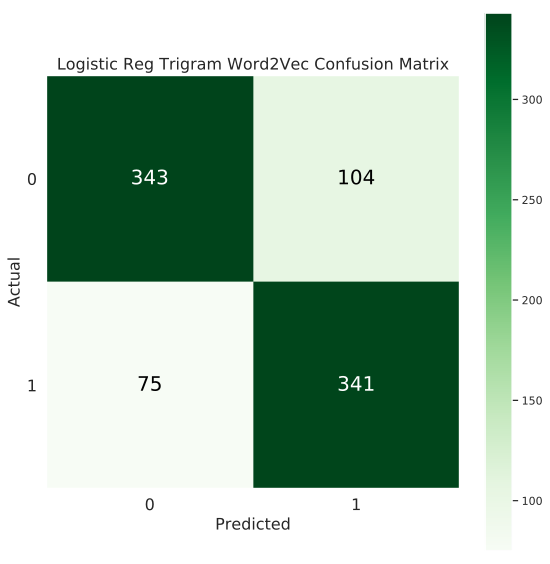

<Figure size 3600x2400 with 0 Axes>

In [23]:
#Print Normalized Confusion Matrix
wv_lr_cm = plot_confusion_matrix(y_test, wv_predicted, file_name='Loggistic_Regression_Word2Vec_Tri_Confusion_Matrix', title='Logistic Reg Trigram Word2Vec Confusion Matrix');
print('W2V Logistic Regression Classifcation Report: \n ', classification_report(y_test,wv_predicted));

Logistic Regression W2V ROC AUC score =  0.7935246730339012


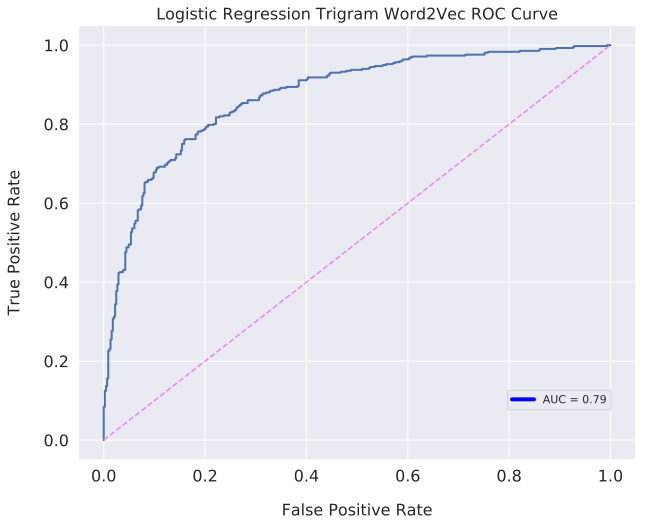

<Figure size 3600x2400 with 0 Axes>

In [24]:
#Generate ROC Curve for Logistic Regression
from matplotlib.lines import Line2D
fpr, tpr, thresholds = roc_curve(y_test, wv_lr.predict_proba(x_test)[:,1])

fig, ax = plt.subplots(figsize=(10, 8))
plt.figure(dpi=600)

ax.plot(fpr, tpr,lw=2)
ax.plot([0,1],[0,1],c='violet',ls='--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('Logistic Regression Trigram Word2Vec ROC Curve',fontsize=16)
custom_lines = [Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['AUC = {:.2f}'.format(roc_auc_score(y_test,wv_predicted))], loc=(.77,.115))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
print(f"\033[1m\033[94mLogistic Regression W2V ROC AUC score = ", roc_auc_score(y_test, wv_predicted))

fig.savefig('./graphs/Logistic_Regression_Tri_W2V_ROC_Curve.png', dpi=600)

# SVM - Trigrams

In [25]:
from sklearn.svm import SVC
svm = SVC(probability=True, gamma='auto')

In [26]:
%%time
svm.fit(x_train, y_train)

CPU times: user 52.2 s, sys: 309 ms, total: 52.5 s
Wall time: 1min 5s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
svm_parameters = {'C': (1, 10, 100, 1000),
                 'degree': (1, 2, 3),
                 'class_weight': (None, 'balanced')}

In [28]:
wv_svm = GridSearchCV(svm, svm_parameters, n_jobs=-1, scoring='f1')

In [29]:
%%time
wv_svm = wv_svm.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 22.5 s, sys: 44.8 ms, total: 22.6 s
Wall time: 10min 56s


In [30]:
wv_svm.best_params_

{'C': 1000, 'class_weight': 'balanced', 'degree': 1}

In [31]:
svm_predicted = wv_svm.predict(x_test)

In [32]:
#Save Model
filename = './models/svm/svm_w2v_trigram.sav'
pickle.dump(svm, open(filename, 'wb'))

#Save Predict Y
filename = './models/svm/ypred_svm_w2v_trigram.sav'
pickle.dump(svm_predicted, open(filename, 'wb'))

Confusion matrix, without normalization
W2V SVM Classifcation Report: 
                precision    recall  f1-score   support

           0       0.84      0.83      0.84       447
           1       0.82      0.84      0.83       416

   micro avg       0.83      0.83      0.83       863
   macro avg       0.83      0.83      0.83       863
weighted avg       0.83      0.83      0.83       863



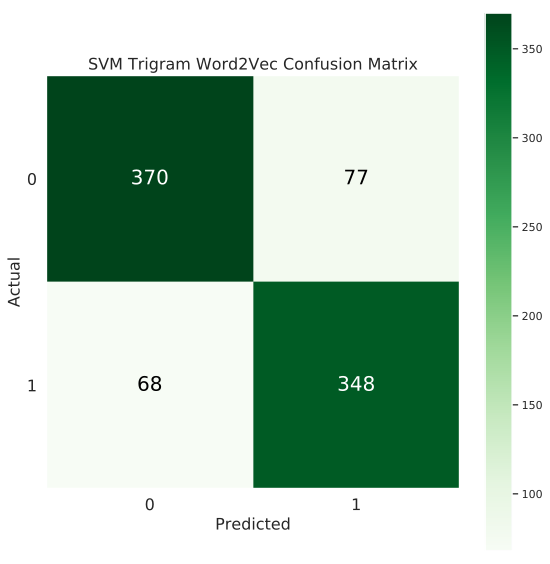

<Figure size 3600x2400 with 0 Axes>

In [33]:
#Print Normalized Confusion Matrix
wv_svm_cm = plot_confusion_matrix(y_test, svm_predicted, file_name='SVM_Word2Vec_Tri_Confusion_Matrix', title='SVM Trigram Word2Vec Confusion Matrix');
print('W2V SVM Classifcation Report: \n ', classification_report(y_test,svm_predicted));

SVM W2V ROC AUC score =  0.832139476854242


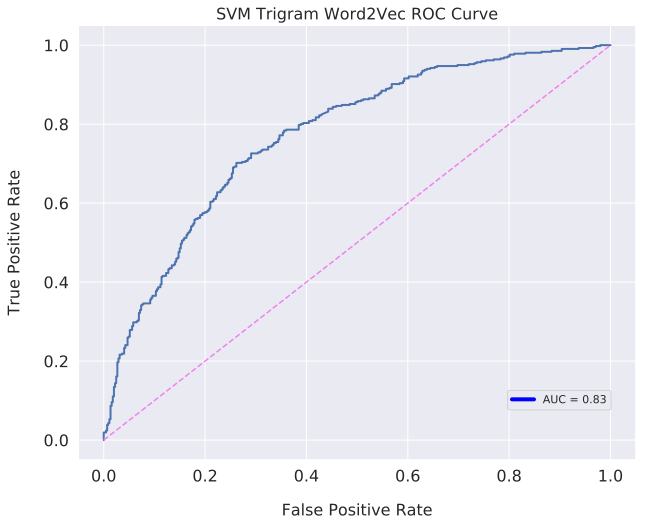

<Figure size 3600x2400 with 0 Axes>

In [34]:
#Generate ROC Curve for SVM
from matplotlib.lines import Line2D
fpr, tpr, thresholds = roc_curve(y_test, svm.predict_proba(x_test)[:,1])

fig, ax = plt.subplots(figsize=(10, 8))
plt.figure(dpi=600)

ax.plot(fpr, tpr,lw=2)
ax.plot([0,1],[0,1],c='violet',ls='--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('SVM Trigram Word2Vec ROC Curve',fontsize=16)
custom_lines = [Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['AUC = {:.2f}'.format(roc_auc_score(y_test,svm_predicted))], loc=(.77,.115))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
print(f"\033[1m\033[94mSVM W2V ROC AUC score = ", roc_auc_score(y_test, svm_predicted))

fig.savefig('./graphs/SVM_W2V_Tri_ROC_Curve.png', dpi=600)

# Random Forest - Trigrams

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [36]:
%%time
rf.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 583 ms, sys: 0 ns, total: 583 ms
Wall time: 780 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
rf_parameters = {'n_estimators': (50, 100, 200),
               'criterion': ('gini', 'entropy'),
               'class_weight': (None, 'balanced'),
               'min_samples_split': (10,20,30)}

In [38]:
wv_rf = GridSearchCV(rf, rf_parameters, n_jobs=-1, scoring='f1')

In [39]:
%%time
wv_rf = wv_rf.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 11.8 s, sys: 33.3 ms, total: 11.9 s
Wall time: 5min 46s


In [40]:
wv_rf.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'min_samples_split': 10,
 'n_estimators': 200}

In [41]:
rf_predicted = wv_rf.predict(x_test)

In [42]:
#Save Model
filename = './models/random_forest/random_forest_w2v_trigram.sav'
pickle.dump(wv_rf, open(filename, 'wb'))

#Save Predict Y
filename = './models/random_forest/ypred_random_forest_w2v_trigram.sav'
pickle.dump(rf_predicted, open(filename, 'wb'))

Confusion matrix, without normalization
W2V Random Forest Classifcation Report: 
                precision    recall  f1-score   support

           0       0.90      0.82      0.85       447
           1       0.82      0.90      0.86       416

   micro avg       0.86      0.86      0.86       863
   macro avg       0.86      0.86      0.86       863
weighted avg       0.86      0.86      0.86       863



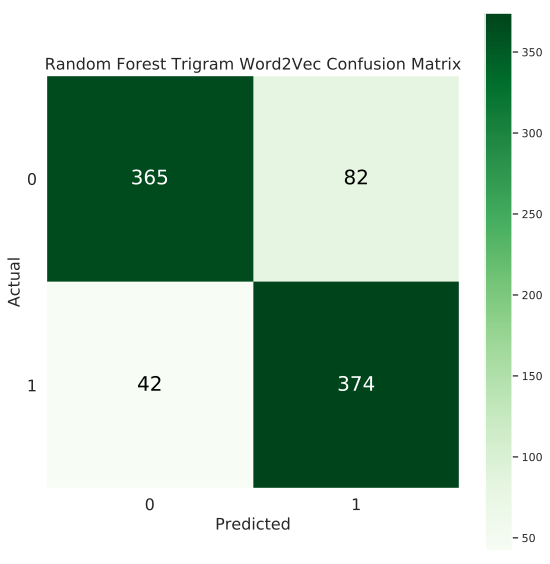

<Figure size 3600x2400 with 0 Axes>

In [43]:
#Print Normalized Confusion Matrix
wv_rf_cm = plot_confusion_matrix(y_test, rf_predicted, file_name='Random_Forest_Word2Vec_Tri_Confusion_Matrix', title='Random Forest Trigram Word2Vec Confusion Matrix');
print('W2V Random Forest Classifcation Report: \n ', classification_report(y_test,rf_predicted));

Random Forest W2V ROC AUC score =  0.8577966356909311


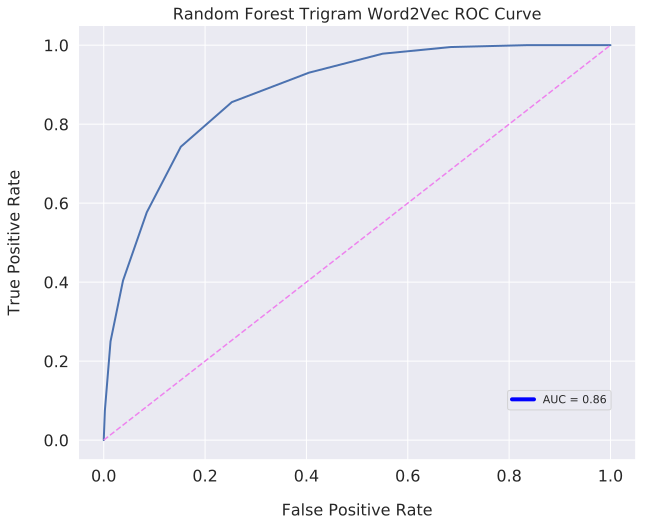

<Figure size 3600x2400 with 0 Axes>

In [44]:
#Generate ROC Curve for Random Forest
from matplotlib.lines import Line2D
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:,1])

fig, ax = plt.subplots(figsize=(10, 8))
plt.figure(dpi=600)

ax.plot(fpr, tpr,lw=2)
ax.plot([0,1],[0,1],c='violet',ls='--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('Random Forest Trigram Word2Vec ROC Curve',fontsize=16)
custom_lines = [Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['AUC = {:.2f}'.format(roc_auc_score(y_test,rf_predicted))], loc=(.77,.115))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
print(f"\033[1m\033[94mRandom Forest W2V ROC AUC score = ", roc_auc_score(y_test, rf_predicted))

fig.savefig('./graphs/Random_Forest_W2V_Tri_ROC_Curve.png', dpi=600)

# Bigrams

In [46]:
x_train, x_test, y_train, y_test = train_test_split(vec_text_bigram, y_response_bi, test_size = 0.2, stratify = y_response_bi, random_state=42)

x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
3055,0.050213,0.049086,0.038440,0.110524,-0.044928,-0.029944,0.014371,-0.080792,0.089500,0.068763,...,-0.005538,-0.000539,-0.060924,0.044833,0.001392,-0.051486,-0.009981,-0.090951,0.015816,0.036807
3293,0.052303,0.023881,0.026397,0.126450,-0.065718,-0.046871,0.004926,-0.042320,0.097570,0.054582,...,-0.059127,0.018142,-0.079700,-0.009927,-0.061142,-0.025814,0.014576,-0.063992,0.000893,0.039856
1200,0.017378,-0.001719,0.008644,0.097872,-0.092410,0.014451,0.055440,-0.003179,0.090729,-0.008823,...,-0.074040,0.069586,-0.051889,-0.012384,-0.010711,0.006838,0.038879,-0.058982,0.032049,0.000802
610,0.021571,0.045966,0.010100,0.024737,-0.049057,-0.025989,0.025383,-0.096670,0.107191,0.050874,...,-0.085418,0.016286,-0.051087,-0.003864,-0.031359,-0.027974,0.036382,-0.039073,0.007244,0.000150
506,0.010969,-0.007127,0.001730,0.077969,-0.053535,0.032393,0.051493,-0.054928,0.093649,0.065620,...,-0.024999,0.021622,-0.043417,0.026650,-0.029160,0.008253,0.019328,-0.059108,0.053813,0.005010


# Logistic Regression - Bigrams

In [47]:
# Logistic Regression - Bigrams
text_pipe_wv_lr_bi = make_pipeline(LogisticRegression(solver='liblinear'))

In [48]:
text_pipe_wv_lr_bi.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [49]:
# Set up grid search to find best parameters for TFIDF and LogReg
wv_lr_parameters_bi = {'logisticregression__penalty': ('l1','l2'),
                'logisticregression__C': (0.01, 0.1, 1),
                'logisticregression__class_weight': (None, 'balanced')}

In [50]:
# Establish grid search instance for log reg
wv_lr_bi = GridSearchCV(text_pipe_wv_lr_bi, wv_lr_parameters_bi, n_jobs=-1, scoring='f1')

In [51]:
# Fit grid search to train data and find best parameters
wv_lr_bi = wv_lr_bi.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [52]:
# Get best parameters for log reg
wv_lr_bi.best_params_

{'logisticregression__C': 1,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2'}

In [53]:
# Predict on test data 
wv_predicted_bi = wv_lr_bi.predict(x_test)

In [54]:
#Save Model
filename = './models/logistic_regression/logist_regression_w2v_bi.sav'
pickle.dump(wv_lr_bi, open(filename, 'wb'))

filename = './models/logistic_regression/ypred_logist_regression_w2v_bi.sav'
pickle.dump(wv_predicted_bi, open(filename, 'wb'))

Confusion matrix, without normalization
W2V Bi Logistic Regression Classifcation Report: 
                precision    recall  f1-score   support

           0       0.80      0.81      0.81       449
           1       0.79      0.79      0.79       420

   micro avg       0.80      0.80      0.80       869
   macro avg       0.80      0.80      0.80       869
weighted avg       0.80      0.80      0.80       869



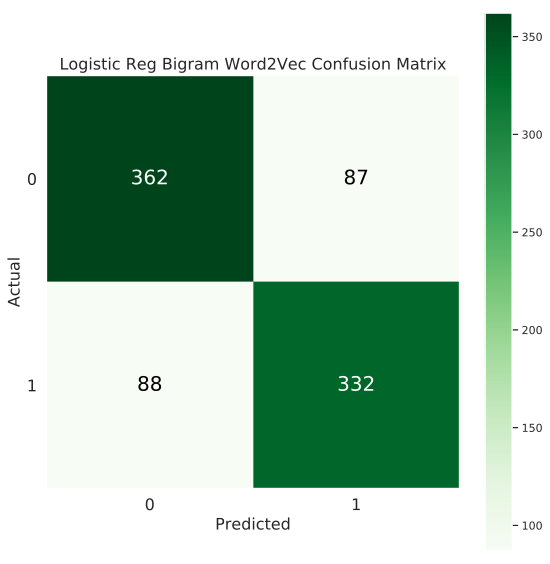

<Figure size 3600x2400 with 0 Axes>

In [55]:
#Print Normalized Confusion Matrix
wv_lr_cm_bi = plot_confusion_matrix(y_test, wv_predicted_bi, file_name='Loggistic_Regression_Word2Vec_bi_Confusion_Matrix', title='Logistic Reg Bigram Word2Vec Confusion Matrix');
print('W2V Bi Logistic Regression Classifcation Report: \n ', classification_report(y_test,wv_predicted_bi));

Logistic Regression W2V Bi ROC AUC score =  0.798356135327182


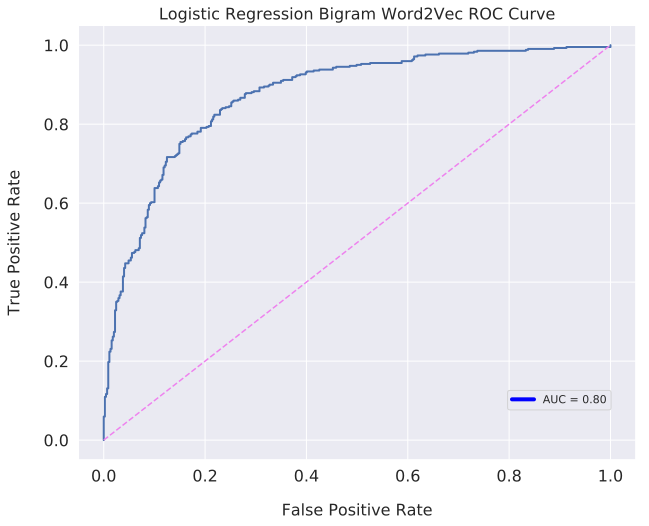

<Figure size 3600x2400 with 0 Axes>

In [56]:
#Generate ROC Curve for Logistic Regression
from matplotlib.lines import Line2D
fpr, tpr, thresholds = roc_curve(y_test, wv_lr_bi.predict_proba(x_test)[:,1])
fig, ax = plt.subplots(figsize=(10, 8))
plt.figure(dpi=600)

ax.plot(fpr, tpr,lw=2)
ax.plot([0,1],[0,1],c='violet',ls='--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('Logistic Regression Bigram Word2Vec ROC Curve',fontsize=16)
custom_lines = [Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['AUC = {:.2f}'.format(roc_auc_score(y_test,wv_predicted_bi))], loc=(.77,.115))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
print(f"\033[1m\033[94mLogistic Regression W2V Bi ROC AUC score = ", roc_auc_score(y_test, wv_predicted_bi))

fig.savefig('./graphs/Logistic_Regression_W2V_bi_ROC_Curve.png', dpi=600)

# SVM - Trigrams

In [57]:
svm_bi = SVC(probability=True, gamma='auto')

In [58]:
%%time
svm_bi.fit(x_train, y_train)

CPU times: user 36.5 s, sys: 226 ms, total: 36.7 s
Wall time: 43.3 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
svm_parameters_bi = {'C': (1, 10, 100, 1000),
                 'degree': (1, 2, 3),
                 'class_weight': (None, 'balanced')}

In [60]:
wv_svm_bi = GridSearchCV(svm_bi, svm_parameters_bi, n_jobs=-1, scoring='f1')

In [61]:
%%time
wv_svm_bi = wv_svm_bi.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 19.9 s, sys: 37.2 ms, total: 19.9 s
Wall time: 11min 8s


In [62]:
wv_svm_bi.best_params_

{'C': 1000, 'class_weight': 'balanced', 'degree': 1}

In [63]:
svm_predicted_bi = wv_svm_bi.predict(x_test)

In [64]:
#Save Model
filename = './models/svm/svm_w2v_bi.sav'
pickle.dump(svm_bi, open(filename, 'wb'))

#Save Predict Y
filename = './models/svm/ypred_svm_w2v_bi.sav'
pickle.dump(svm_predicted_bi, open(filename, 'wb'))

Confusion matrix, without normalization
W2V Bi SVM Classifcation Report: 
                precision    recall  f1-score   support

           0       0.83      0.84      0.84       449
           1       0.83      0.82      0.83       420

   micro avg       0.83      0.83      0.83       869
   macro avg       0.83      0.83      0.83       869
weighted avg       0.83      0.83      0.83       869



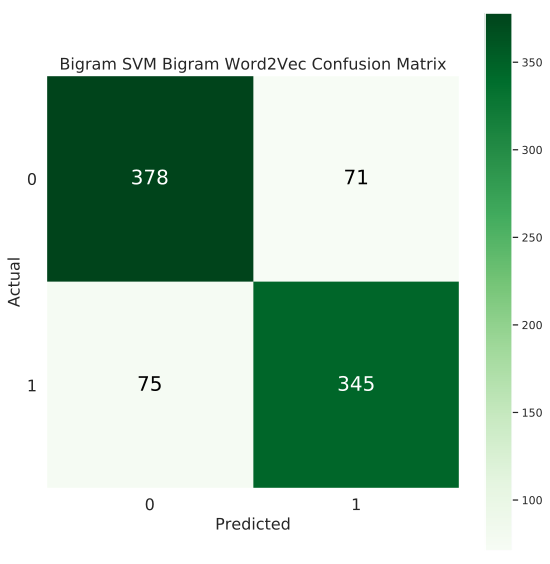

<Figure size 3600x2400 with 0 Axes>

In [65]:
#Print Normalized Confusion Matrix
wv_svm_cm_bi = plot_confusion_matrix(y_test, svm_predicted_bi, file_name='SVM_Word2Vec_Bi_Confusion_Matrix', title='Bigram SVM Bigram Word2Vec Confusion Matrix');
print('W2V Bi SVM Classifcation Report: \n ', classification_report(y_test,svm_predicted_bi));

SVM W2V Bigram ROC AUC score =  0.8316496977410118


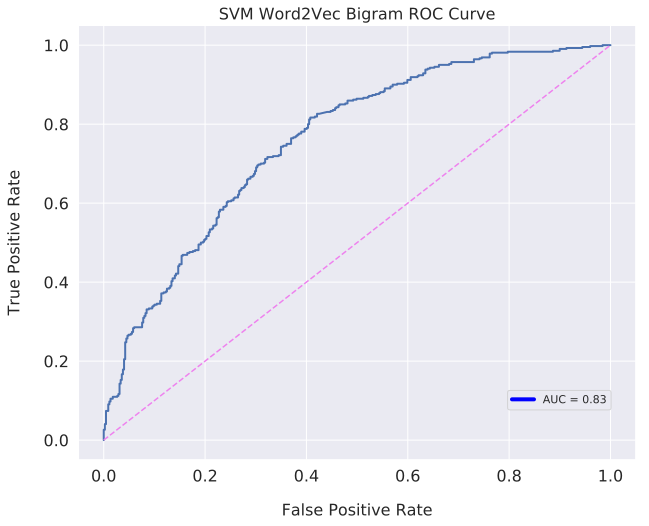

<Figure size 3600x2400 with 0 Axes>

In [66]:
#Generate ROC Curve for SVM
from matplotlib.lines import Line2D
fpr, tpr, thresholds = roc_curve(y_test, svm_bi.predict_proba(x_test)[:,1])

fig, ax = plt.subplots(figsize=(10, 8))
plt.figure(dpi=600)

ax.plot(fpr, tpr,lw=2)
ax.plot([0,1],[0,1],c='violet',ls='--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('SVM Word2Vec Bigram ROC Curve',fontsize=16)
custom_lines = [Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['AUC = {:.2f}'.format(roc_auc_score(y_test,svm_predicted_bi))], loc=(.77,.115))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
print(f"\033[1m\033[94mSVM W2V Bigram ROC AUC score = ", roc_auc_score(y_test, svm_predicted_bi))

fig.savefig('./graphs/SVM_W2V_Bi_ROC_Curve.png', dpi=600)

# Random Forest - Bigrams

In [67]:
rf_bi = RandomForestClassifier()

In [68]:
%%time
rf_bi.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 595 ms, sys: 50 µs, total: 595 ms
Wall time: 663 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
rf_parameters_bi = {'n_estimators': (50, 100, 200),
               'criterion': ('gini', 'entropy'),
               'class_weight': (None, 'balanced'),
               'min_samples_split': (10,20,30)}

In [70]:
wv_rf_bi = GridSearchCV(rf_bi, rf_parameters_bi, n_jobs=-1, scoring='f1')

In [71]:
%%time
wv_rf_bi = wv_rf_bi.fit(x_train, y_train)

/home/bakirhosting/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 11.9 s, sys: 26.8 ms, total: 12 s
Wall time: 5min 46s


In [72]:
wv_rf_bi.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'min_samples_split': 10,
 'n_estimators': 200}

In [73]:
rf_predicted_bi = wv_rf_bi.predict(x_test)

In [74]:
#Save Model
filename = './models/random_forest/random_forest_w2v_bi.sav'
pickle.dump(wv_rf_bi, open(filename, 'wb'))

#Save Predict Y
filename = './models/random_forest/ypred_random_forest_w2v_bi.sav'
pickle.dump(rf_predicted_bi, open(filename, 'wb'))

Confusion matrix, without normalization
W2V Bigram Random Forest Classifcation Report: 
                precision    recall  f1-score   support

           0       0.87      0.84      0.85       449
           1       0.84      0.86      0.85       420

   micro avg       0.85      0.85      0.85       869
   macro avg       0.85      0.85      0.85       869
weighted avg       0.85      0.85      0.85       869



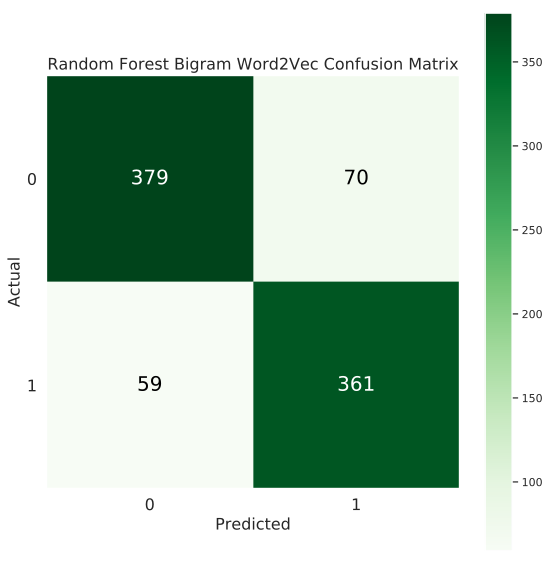

<Figure size 3600x2400 with 0 Axes>

In [75]:
#Print Normalized Confusion Matrix
wv_rf_cm_bi = plot_confusion_matrix(y_test, rf_predicted_bi, file_name='Random_Forest_Word2Vec_bi_Confusion_Matrix', title='Random Forest Bigram Word2Vec Confusion Matrix');
print('W2V Bigram Random Forest Classifcation Report: \n ', classification_report(y_test,rf_predicted_bi));

Random Forest Bigram W2V ROC AUC score =  0.8518109025347333


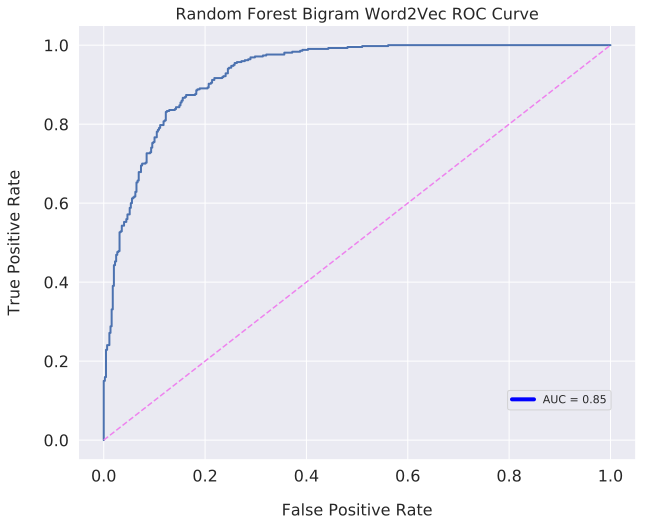

<Figure size 3600x2400 with 0 Axes>

In [76]:
#Generate ROC Curve for Random Forest
from matplotlib.lines import Line2D
fpr, tpr, thresholds = roc_curve(y_test, wv_rf_bi.predict_proba(x_test)[:,1])

fig, ax = plt.subplots(figsize=(10, 8))
plt.figure(dpi=600)

ax.plot(fpr, tpr,lw=2)
ax.plot([0,1],[0,1],c='violet',ls='--')
ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('Random Forest Bigram Word2Vec ROC Curve',fontsize=16)
custom_lines = [Line2D([0], [0], color='blue', lw=4)]
ax.legend(custom_lines, ['AUC = {:.2f}'.format(roc_auc_score(y_test,rf_predicted_bi))], loc=(.77,.115))

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

ax.yaxis.set_label_coords(-0.1,0.5)
ax.xaxis.set_label_coords(0.5,-0.1)
print(f"\033[1m\033[94mRandom Forest Bigram W2V ROC AUC score = ", roc_auc_score(y_test, rf_predicted_bi))

fig.savefig('./graphs/Random_Forest_W2V_Bi_ROC_Curve.png', dpi=600)